# Modelli generativi {#sec-generative-models}

**Prerequisiti**

- Leggere il @sec-discr-rv-distributions.

**Concetti e Competenze Chiave**

- Comprensione dei modelli generativi e della loro applicazione nell'inferenza statistica.
- Gestione dei dati censurati, in particolare per stimare correttamente le probabilità di un evento (adozione).
- Utilizzo del linguaggio Stan per implementare modelli bayesiani, integrando dati completi e censurati.
- Importanza di includere tutte le informazioni disponibili nei modelli per evitare bias nelle stime.

**Preparazione del Notebook**

In [1]:
import os
import tempfile
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import statistics as stat
import cmdstanpy
from cmdstanpy import CmdStanModel

In [6]:
seed: int = sum(map(ord, "generative_models"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduzione {.unnumbered}

In questo capitolo presenteremo uno dei tutorial utilizzati da Richard McElreath nella sua presentazione *Introduction to Probabilistic Programming with Stan* alla [StanCon](https://github.com/rmcelreath/intro_to_stan_stancon2024) a Oxford nel 2024. Lo scopo del tutorial è spiegare come i modelli implementati in Stan siano modelli generativi. Questo significa che i modelli mettono in relazione in modo esplicito le ipotesi scientifiche o meccaniche sul funzionamento della natura con l'algoritmo di inferenza.

Per scrivere un programma Stan, è quindi fondamentale chiarire gli obiettivi dell'analisi, rendere trasparente e verificabile la logica dell'estimatore, e testare il modello in modo efficace.

L'esempio discusso da Richard McElreath riguarda l'analisi di un database contenente informazioni su 22.356 gatti provenienti dall'Austin, Texas Animal Center. Per ciascun gatto presente nel rifugio, sappiamo quanti giorni è rimasto senza essere adottato o, se è stato adottato, quanti giorni ha trascorso nel rifugio prima dell'adozione. Abbiamo inoltre informazioni sul colore del gatto, distinguendo se è nero o di un altro colore.

In [31]:
# URL for the data file
urlfile = (
    "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/AustinCats.csv"
)

# Read the CSV file directly from the URL
d = pd.read_csv(urlfile, sep=";")

# Display the first few rows of the dataframe
d.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1


La domanda che Richard McElreath si pone riguarda la stima del tempo medio di permanenza di un gatto nel rifugio prima di essere adottato. Inoltre, si interroga se questo tempo medio vari in funzione del colore del gatto (nero vs altri colori). Oltre a stimare il tempo medio di permanenza per ciascun gruppo, è fondamentale anche stimare il grado di incertezza delle nostre stime.

McElreath ipotizza che la probabilità giornaliera di adozione dipenda dal colore del gatto, e che la probabilità di dover attendere $D$ giorni prima dell'adozione sia data da:

$$
p(1− p)^{D−1}.
$$

Questo rappresenta il modello generativo che riflette il processo probabilistico che porta all'adozione. Richard McElreath dimostra come costruire un modello generativo, che può essere utilizzato per costruire e testare un modello statistico.

Il modello bayesiano è costituito da tre componenti principali:

1. **Verosimiglianza**:
$$
Pr(D | p) = p(1− p)^{D−1},
$$
che rappresenta la probabilità di osservare $D$ giorni di attesa fino all'adozione, dato un certo valore di $p$ (la probabilità giornaliera di adozione).

2. **Prior**:
$$
Pr(p) = \text{Beta}(1,10),
$$
che rappresenta la nostra assunzione a priori sulla distribuzione di $p$, dove assumiamo che la probabilità di adozione sia bassa.

3. **Distribuzione a posteriori**:
$$
Pr(p | D) ∝ Pr(D | p) \cdot Pr(p),
$$
che combina la verosimiglianza con il prior per ottenere la distribuzione a posteriori, che rappresenta la nostra conoscenza aggiornata di $p$ dopo aver osservato i dati $D$.

Il nostro obiettivo è costruire un modello in Stan che implementi questo modello statistico, permettendoci di stimare la probabilità giornaliera di adozione per gatti di colore diverso, insieme alle incertezze associate a tali stime.

Il modello Stan presentato da Richard McElreath è fornito qui sotto.

In [14]:
stan_file = os.path.join(project_directory, "stan", "cats_model.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

// all events, including censored
data {
  int N;
  array[N] int adopted; // 1/0 indicator
  array[N] int days; // days until event
  array[N] int color; // 1=black, 2=other
}
parameters {
  vector<lower=0, upper=1>[2] p;
}
model {
  p ~ beta(1, 10);
  for (i in 1 : N) {
    real P = p[color[i]];
    if (adopted[i] == 1) {
      target += log((1 - P) ^ (days[i] - 1) * P);
    } else {
      target += log((1 - P) ^ days[i]);
    }
  }
}



La riga di codice `real P = p[color[i]];` significa che la probabilità `P` di adozione per il gatto `i` dipende dal colore del gatto. Ecco una spiegazione più dettagliata:

- **`p`**: Questo è il vettore delle probabilità di adozione per ciascun gruppo di colore. Nel modello, `p` è un vettore di lunghezza 2, che contiene le probabilità di adozione per due categorie di colore: `p[1]` per il colore 1 (ad esempio, **nero**) e `p[2]` per il colore 2 (ad esempio, **altri colori**).
  
- **`color[i]`**: Questo è un array che contiene, per ciascun soggetto, un valore intero che indica il colore del soggetto. Per esempio:
  - `color[i] = 1` potrebbe indicare che il soggetto $i$ è nero.
  - `color[i] = 2` potrebbe indicare che il soggetto $i$ è di un altro colore.

- **`P = p[color[i]]`**: Questa espressione estrae la probabilità $P$ di adozione per il soggetto $i$ dal vettore `p`, in base al suo colore. Quindi, se `color[i]` è 1, $P$ sarà uguale a `p[1]`, mentre se `color[i]` è 2, $P$ sarà uguale a `p[2]`.

Questo approccio permette di testare se il colore del gatto ha un effetto significativo sulla probabilità di adozione, riflettendo la possibilità che il colore possa influenzare le probabilità di essere adottato.

Se il gatto è stato adottato, la riga

```stan
target += log((1 - P) ^ (days[i] - 1) * P);
```

è un'espressione che aggiunge il logaritmo della probabilità di osservare un certo numero di giorni prima dell'adozione nel modello basato sulla **distribuzione geometrica**. Vediamo cosa significa in dettaglio.

Nella distribuzione geometrica, stiamo modellando il **numero di tentativi falliti** (o giorni in cui l'adozione non è avvenuta) prima di osservare un successo (l'adozione).

1. **`P`**: È la probabilità che l'adozione avvenga in un dato giorno (successo).
2. **`1 - P`**: È la probabilità che l'adozione **non** avvenga in un dato giorno (fallimento).
3. **`days[i] - 1`**: Indica il numero di giorni falliti prima dell'adozione. La distribuzione geometrica modella i fallimenti fino a che si verifica il primo successo, quindi `days[i] - 1` rappresenta i giorni in cui l'adozione non è avvenuta prima di avere successo.

La formula **$(1 - P)^{(days[i] - 1)} \cdot P$** rappresenta la probabilità che l'adozione avvenga esattamente al giorno $days[i]$, ossia:

- **$(1 - P)^{(days[i] - 1)}$**: La probabilità che l'adozione non avvenga per $days[i] - 1$ giorni consecutivi.
- **$\cdot P$**: La probabilità che l'adozione avvenga esattamente al giorno $days[i]$ (il primo successo).

Quindi, questa formula sta modellando la probabilità di un certo numero di giorni di attesa fino all'adozione usando la distribuzione geometrica.

In Stan, la verosimiglianza del modello è rappresentata come la somma dei logaritmi delle probabilità. La funzione `target` tiene traccia del log-verosimiglianza totale. Aggiungendo il logaritmo della probabilità con `target +=`, Stan massimizza la funzione log-verosimiglianza durante il processo di campionamento.

- **`log((1 - P) ^ (days[i] - 1) * P)`**: Prendiamo il logaritmo della probabilità che il soggetto venga adottato dopo $days[i]$ giorni.
- Il logaritmo viene usato per garantire stabilità numerica e perché il logaritmo della funzione verosimiglianza è più facile da sommare nel contesto dell'inferenza bayesiana.

Possiamo riscrivere la formula come:

$$
\text{log}((1 - P)^{days[i] - 1} \cdot P) = (days[i] - 1) \cdot \log(1 - P) + \log(P)
$$

Questa forma è equivalente e più efficiente dal punto di vista numerico. Se volessimo scrivere il codice usando questa riscrittura, sarebbe:

```stan
target += (days[i] - 1) * log(1 - P) + log(P);
```

In sintesi:

- **`(1 - P)^{days[i] - 1}`**: Probabilità che l'adozione non avvenga nei primi $days[i] - 1$ giorni.
- **`P`**: Probabilità che l'adozione avvenga esattamente al giorno $days[i]$.
- **`log()`**: Usiamo il logaritmo per sommare le probabilità su più osservazioni in modo numericamente stabile.
- **`target +=`**: Aggiungiamo la log-verosimiglianza al totale, che Stan utilizza per ottimizzare il modello e campionare i parametri.

Questo approccio modella esattamente il tempo fino al successo (adozione) utilizzando la distribuzione geometrica.

Se invece il gatto non viene adottato, viene eseguita l'istruzione:

```stan
target += log((1 - P) ^ days[i]);
```

Questa espressione modella il caso in cui il gatto **non viene adottato** entro il periodo osservato. È un esempio di **dati censurati**, cioè sappiamo che l'evento di adozione non è avvenuto, ma non sappiamo se accadrà in futuro.

Vediamo nel dettaglio cosa rappresentano i termini:

1. **`P`**: È la probabilità giornaliera che il gatto venga adottato.
2. **`1 - P`**: È la probabilità giornaliera che il gatto **non venga adottato** (fallimento).
3. **`days[i]`**: È il numero di giorni osservati in cui il gatto non è stato adottato.

Se il gatto **non viene adottato** in $days[i]$ giorni, allora la probabilità di questo evento è data dal fatto che l'adozione non è avvenuta per tutti i $days[i]$ giorni osservati. Questa probabilità è:

$$
(1 - P)^{days[i]}
$$

In altre parole, per ogni giorno osservato, la probabilità che il gatto **non venga adottato** è $1 - P$, e poiché osserviamo $days[i]$ giorni senza adozione, moltiplichiamo questa probabilità per se stessa $days[i]$ volte. Quindi, la probabilità complessiva di osservare $days[i]$ giorni senza adozione è $(1 - P)^{days[i]}$.

Questo passaggio è fondamentale perché rappresenta i **dati censurati**, cioè i casi in cui il gatto non è stato adottato entro il periodo osservato. Senza questa parte del modello, non staremmo prendendo in considerazione le informazioni fornite dai soggetti che non sono stati adottati, il che porterebbe a una stima incompleta o distorta delle probabilità di adozione.

In Stan, come già detto, le probabilità vengono sommate nel logaritmo per stabilità numerica. Quindi, quando diciamo:

```stan
target += log((1 - P) ^ days[i]);
```

stiamo aggiungendo il logaritmo della probabilità che il gatto **non sia stato adottato** in $days[i]$ giorni. Questo passaggio assicura che anche i gatti che non sono stati adottati contribuiscano al calcolo della verosimiglianza, migliorando la stima complessiva del modello.

Analogamente al caso dell'adozione, possiamo riscrivere questa espressione in modo più efficiente dal punto di vista numerico:

$$
\text{log}((1 - P)^{days[i]}) = days[i] \cdot \log(1 - P)
$$

Quindi, la versione più efficiente di questa istruzione in Stan è:

```stan
target += days[i] * log(1 - P);
```

In sintesi:

- **`(1 - P) ^ days[i]`**: Modella la probabilità che il gatto **non sia stato adottato** per $days[i]$ giorni consecutivi.
- **Dati censurati**: È necessario modellare i casi in cui l'adozione non avviene per assicurarsi che anche questi dati contribuiscano alla stima complessiva.
- **`target += log()`**: Il logaritmo viene utilizzato per stabilità numerica e per sommare correttamente le probabilità nel contesto dell'inferenza bayesiana.

Questa istruzione è quindi fondamentale per tenere conto di tutte le informazioni, comprese quelle derivanti da casi in cui l'adozione non è avvenuta.

Compiliamo il modello:

In [13]:
model = CmdStanModel(stan_file=stan_file)

Definiamo il dizionario con i dati:

In [24]:
# Create the 'adopted' indicator (1 if the event is Adoption, 0 otherwise)
d["adopted"] = np.where(d["out_event"] == "Adoption", 1, 0)

# Create the 'color' indicator (1 if the cat is black, 2 for all other colors)
d["color"] = np.where(d["color"].str.contains("Black", case=False), 1, 2)

# Select the relevant columns for the Stan model
stan_data = {
    "N": len(d),
    "adopted": d["adopted"].tolist(),
    "days": d["days_to_event"].tolist(),
    "color": d["color"].tolist(),
}

Eseguiamo il campionamento:

In [25]:
fit = model.sample(
    data=stan_data,
    iter_warmup = 2_000,
    iter_sampling = 2_000,
    chains = 4,
    seed = 123,
    show_progress = False, 
    show_console = False
)

11:38:02 - cmdstanpy - INFO - CmdStan start processing
11:38:02 - cmdstanpy - INFO - Chain [1] start processing
11:38:02 - cmdstanpy - INFO - Chain [2] start processing
11:38:02 - cmdstanpy - INFO - Chain [3] start processing
11:38:02 - cmdstanpy - INFO - Chain [4] start processing
11:38:36 - cmdstanpy - INFO - Chain [1] done processing
11:38:37 - cmdstanpy - INFO - Chain [3] done processing
11:38:38 - cmdstanpy - INFO - Chain [4] done processing
11:38:38 - cmdstanpy - INFO - Chain [2] done processing


Estraiamo i campioni a posteriori.

In [26]:
posterior_samples = fit.draws_pd()  # Ottiene i campioni posteriori come DataFrame

Generiamo una figura con la distribuzione a posteriori del tempo di attesa medio, distinguendo i gatti neri dai gatti di altri colori.

In [27]:
# I parametri p sono denominati "p[1]" per i gatti neri e "p[2]" per gli altri colori
p_black = posterior_samples["p[1]"]  # Probabilità di adozione per i gatti neri
p_other = posterior_samples["p[2]"]  # Probabilità di adozione per gli altri colori

In [28]:
# Step 2: Calcola il numero atteso di giorni fino all'adozione
# Numero atteso di giorni = 1 / p
expected_days_black = 1 / p_black
expected_days_other = 1 / p_other

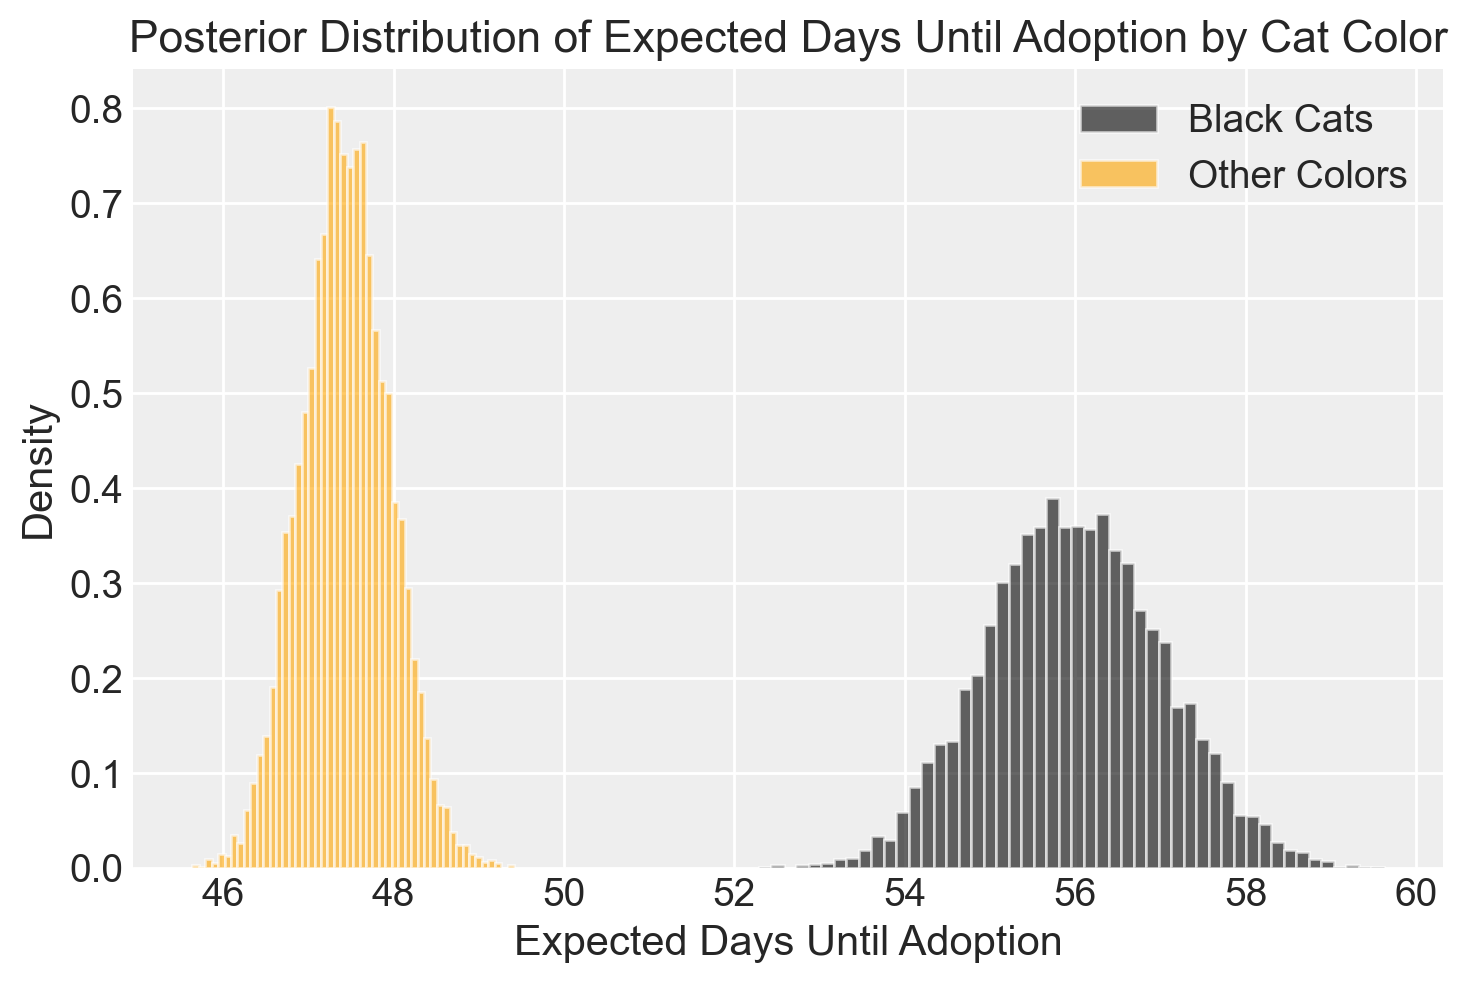

In [30]:
# Plot della distribuzione per i gatti neri
plt.hist(
    expected_days_black,
    bins=50,
    alpha=0.6,
    label="Black Cats",
    color="black",
    density=True,
)

# Plot della distribuzione per gli altri colori
plt.hist(
    expected_days_other,
    bins=50,
    alpha=0.6,
    label="Other Colors",
    color="orange",
    density=True,
)

# Aggiungi etichette e titolo
plt.xlabel("Expected Days Until Adoption")
plt.ylabel("Density")
plt.title("Posterior Distribution of Expected Days Until Adoption by Cat Color")
plt.legend()
plt.show()

In conclusione, il tempo medio di attesa per l'adozione di un gatto nero risulta essere almeno 10 giorni più lungo rispetto a quello di un gatto di colore diverso.

Consideriamo ora un modello che non considera i dati censurati, ossia non include i gatti che non sono ancora stati adottati. Di seguito si trova il modello modificato:

In [32]:
stan_file = os.path.join(project_directory, "stan", "cats_model_2.stan")
model2 = CmdStanModel(stan_file=stan_file)
print(model2.code())

13:12:16 - cmdstanpy - INFO - compiling stan file /Users/corradocaudek/_repositories/psicometria/stan/cats_model_2.stan to exe file /Users/corradocaudek/_repositories/psicometria/stan/cats_model_2
13:12:32 - cmdstanpy - INFO - compiled model executable: /Users/corradocaudek/_repositories/psicometria/stan/cats_model_2


data {
  int N;
  array[N] int adopted; // 1/0 indicator (adopted = 1, only adopted cats considered)
  array[N] int days; // days until event (adoption)
  array[N] int color; // 1 = black, 2 = other
}
parameters {
  vector<lower=0, upper=1>[2] p; // Probabilità di adozione per ciascun colore
}
model {
  p ~ beta(1, 10); // Prior sulla probabilità di adozione
  
  for (i in 1 : N) {
    if (adopted[i] == 1) {
      // Consideriamo solo i gatti adottati
      real P = p[color[i]]; // Probabilità di adozione per il colore del gatto
      target += log((1 - P) ^ (days[i] - 1) * P); // Verosimiglianza per l'adozione
    }
  }
}



In [33]:
fit2 = model2.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    chains=4,
    seed=123,
    show_progress=False,
    show_console=False,
)

13:12:44 - cmdstanpy - INFO - CmdStan start processing
13:12:44 - cmdstanpy - INFO - Chain [1] start processing
13:12:44 - cmdstanpy - INFO - Chain [2] start processing
13:12:44 - cmdstanpy - INFO - Chain [3] start processing
13:12:44 - cmdstanpy - INFO - Chain [4] start processing
13:13:04 - cmdstanpy - INFO - Chain [4] done processing
13:13:04 - cmdstanpy - INFO - Chain [2] done processing
13:13:05 - cmdstanpy - INFO - Chain [3] done processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
posterior_samples_2 = fit2.draws_pd()  # Ottiene i campioni posteriori come DataFrame

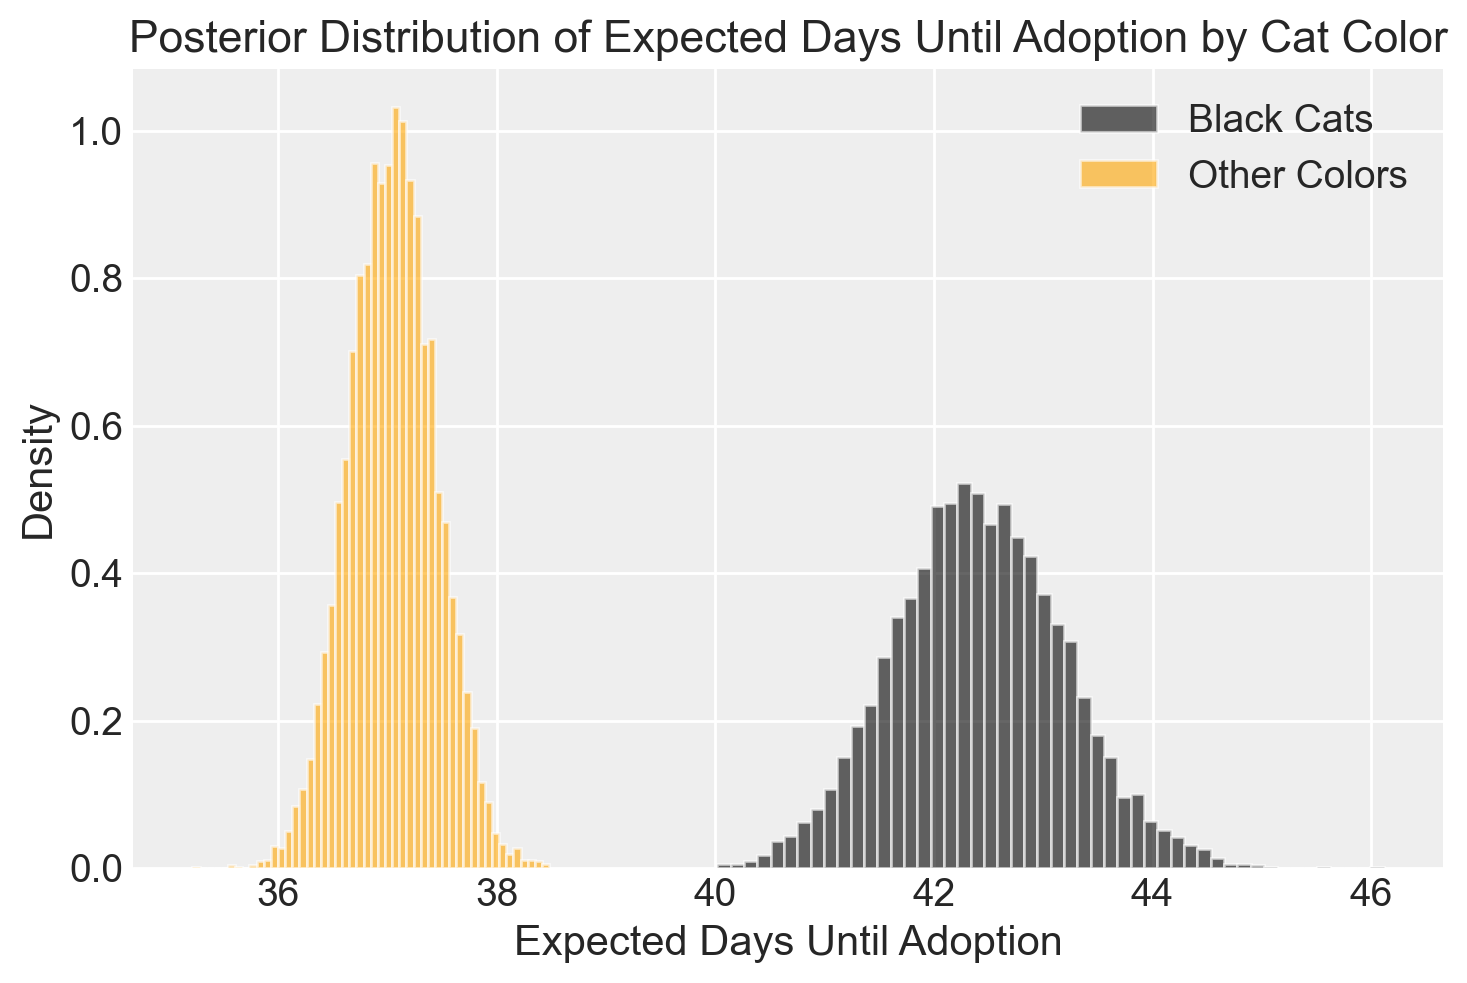

In [36]:
# I parametri p sono denominati "p[1]" per i gatti neri e "p[2]" per gli altri colori
p_black = posterior_samples_2["p[1]"]  # Probabilità di adozione per i gatti neri
p_other = posterior_samples_2["p[2]"]  # Probabilità di adozione per gli altri colori

expected_days_black = 1 / p_black
expected_days_other = 1 / p_other

# Plot della distribuzione per i gatti neri
plt.hist(
    expected_days_black,
    bins=50,
    alpha=0.6,
    label="Black Cats",
    color="black",
    density=True,
)

# Plot della distribuzione per gli altri colori
plt.hist(
    expected_days_other,
    bins=50,
    alpha=0.6,
    label="Other Colors",
    color="orange",
    density=True,
)

# Aggiungi etichette e titolo
plt.xlabel("Expected Days Until Adoption")
plt.ylabel("Density")
plt.title("Posterior Distribution of Expected Days Until Adoption by Cat Color")
plt.legend()
plt.show()

In questo caso, notiamo che la differenza tra i tempi di attesa dei due gruppi si è dimezzata rispetto alla stima precedente. In altre parole, se trascuriamo le informazioni relative ai gatti che sono ancora presenti nel rifugio ma non sono stati ancora adottati (e che potrebbero essere adottati in futuro), rischiamo di ottenere una stima distorta dei parametri del modello. Ignorare i gatti non ancora adottati introduce un bias verso l'alto nelle stime — è come considerare solo i successi e ignorare i fallimenti.

Questo stesso bias si manifesta anche quando calcoliamo le statistiche descrittive, se escludiamo i dati relativi ai gatti che non sono ancora stati adottati.

In [37]:
# Filter the dataset to only include adopted cats
adopted_cats = d[d["out_event"] == "Adoption"]

# Create a color indicator (1 for black, 2 for other)
adopted_cats["color_category"] = adopted_cats["color"].apply(
    lambda x: "black" if "Black" in x else "other"
)

# Calculate the mean waiting time (days_to_event) for black cats and other colors
mean_wait_black = adopted_cats[adopted_cats["color_category"] == "black"][
    "days_to_event"
].mean()
mean_wait_other = adopted_cats[adopted_cats["color_category"] == "other"][
    "days_to_event"
].mean()

# Display the results
mean_wait_black, mean_wait_other

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_3816/2371120338.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_cats["color_category"] = adopted_cats["color"].apply(


(42.41035441278666, 37.03930131004367)

## Commenti Conclusivi

In questo capitolo, abbiamo esplorato come l'analisi dei dati possa essere influenzata dalla presenza di dati censurati, ovvero di osservazioni incomplete (nell'esempio, gatti che non sono ancora stati adottati). Abbiamo visto che ignorare questi dati può portare a stime distorte dei tempi di attesa. Il modello generativo implementato in Stan ci ha permesso di affrontare correttamente queste problematiche, integrando sia i dati completi che quelli censurati, fornendo stime più accurate e un quadro più completo del fenomeno in esame. Questo esempio sottolinea l'importanza di considerare tutte le informazioni disponibili e di scegliere il modello statistico appropriato per evitare distorsioni nelle analisi.

Nel concludere il suo tutorial su Stan, Richard McElreath riassume i compiti principali per un moderno data analyst:

- Imparare i concetti di base della programmazione probabilistica.
- Imparare a esprimere le idee in termini di modelli probabilistici.
- Conoscere le convenzioni del linguaggio Stan.
- Seguire un flusso di lavoro ragionevole e affidabile.

## Informazioni sull'Ambiente di Sviluppo

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Wed Sep 11 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanpy: 1.2.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
arviz     : 0.18.0
pandas    : 2.2.2
matplotlib: 3.9.1
cmdstanpy : 1.2.4
logging   : 0.5.1.2
numpy     : 1.26.4

Watermark: 2.4.3

